In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict
from sklearn.metrics import adjusted_rand_score, auc
from scipy.stats import rankdata
import itertools

In [3]:
from pygraphs.cluster import KKMeans, KWard, KMeans_sklearn, Ward_sklearn
from pygraphs.graphs.generator import StochasticBlockModel, RubanovModel
from pygraphs.measure import kernels, distances, scaler
from pygraphs.measure.kernel import Kernel
from pygraphs.scenario import ParallelByGraphs, RejectCurve, d3_colors, plot_results
from pygraphs.scorer import rand_index, triplet_measure, ranking

In [4]:
# optimal_params = { # (100, 2, 0.3, 0.1)
#     "CT H": 0.00,
#     "SP K": 0.00,
#     "Comm H": 0.36,
#     "logComm H": 0.54,
#     "Heat H": 0.74,
#     "Walk H": 0.76,
#     "logHeat H": 0.46,
#     "SCT H": 0.50,
#     "logFor H": 0.40,
#     "RSP K": 0.98,
#     "For H": 0.98,
#     "FE K": 0.92,
#     "SCCT H": 0.74,
#     "pWalk H": 0.80,
#     "SP-CT H": 0.04
# }

optimal_params = {
    'pWalk': 1.00,
    'Walk': 0.03,
    'For': 0.00,
    'logFor': 0.27,
    'Comm': 0.33,
    'logComm': 0.10,
    'Heat': 0.50,
    'logHeat': 0.03,
    'NHeat': 0.93,
    'logNHeat': 0.07,
    'SCT': 0.90,
    'SCCT': 0.70,
    'RSP': 0.83,
    'FE': 0.60,
    'PPR': 0.00,
    'logPPR': 0.03,
    'ModifPPR': 0.00,
    'logModifPPR': 0.07,
    'HeatPPR': 0.90,
    'logHeatPPR': 0.03,
    'SP-CT': 1.00
}

# Triplet measure vs in-out AUC vs k-means ARI

Эксперимент с ранговыми корреляциями триплетного скора (берем все тройки, где 2 из 3 семплов относятся к одному классу, проверяем условие d(s1, s2) < d(s1, s3), мера – доля правильных ответов) vs in-out AUC vs k-means ARI.

In [5]:
graphs, _ = StochasticBlockModel(100, 2, p_in=0.3, p_out=0.1).generate_graphs(100)
y_true = [y_true_sample for A, y_true_sample in graphs]

Сначала насчитаем все кернелы по заранее определенным оптимальным параметрам

In [6]:
K = defaultdict(list)
D = defaultdict(list)
for kernel, distance in tqdm(zip(kernels, distances), total=len(kernels)):
    for A, _ in graphs:
        param = optimal_params[kernel.name]
        K[kernel.name].append(kernel(A).get_K(param))
        D[kernel.name].append(distance(A).get_D(param))

Теперь насчитаем k-means ARI

In [7]:
KKMeans_ARI = defaultdict(list)
for kernel_name, K_k in tqdm(K.items()):
    for idx, K_k_g in enumerate(K_k):
        try:
            y_pred = KKMeans(2).fit_predict(K_k_g)
            ari = adjusted_rand_score(y_true[idx], y_pred)
            KKMeans_ARI[kernel_name].append(ari)
        except ValueError as e:
            print(kernel_name, idx)

KKMeans_ARI_mean = dict([(kernel_name, np.mean(scores)) for kernel_name, scores in KKMeans_ARI.items()])
sorted(KKMeans_ARI_mean.items(), key=lambda x: -x[1])

[('Walk', 0.9780948725914067),
 ('logModifPPR', 0.9765189990507879),
 ('logFor', 0.9749674143749283),
 ('logNHeat', 0.9745349727976754),
 ('logComm', 0.9741511000461357),
 ('logHeatPPR', 0.9737591521600504),
 ('logHeat', 0.9737510511647026),
 ('logPPR', 0.972983365493495),
 ('SCCT', 0.9721508689666148),
 ('Heat', 0.952476985330417),
 ('RSP', 0.5896396620750748),
 ('Comm', 0.5124872347398642),
 ('FE', 0.45580045448090084),
 ('SP-CT', 0.1436152211243209),
 ('SCT', 0.13926320092642105),
 ('PPR', -0.0007776254361945438),
 ('ModifPPR', -0.0008539843806941448),
 ('For', -0.002778768433255417),
 ('NHeat', -0.003030075632031026),
 ('HeatPPR', -0.005039833061285978),
 ('pWalk', -0.006269366151052321)]

In [8]:
KWard_ARI = defaultdict(list)
for kernel_name, K_k in tqdm(K.items()):
    for idx, K_k_g in enumerate(K_k):
        try:
            y_pred = KWard(2).fit_predict(K_k_g)
            ari = adjusted_rand_score(y_true[idx], y_pred)
            KWard_ARI[kernel_name].append(ari)
        except ValueError as e:
            print(kernel_name, idx)

KWard_ARI_mean = dict([(kernel_name, np.mean(scores)) for kernel_name, scores in KWard_ARI.items()])
sorted(KWard_ARI_mean.items(), key=lambda x: -x[1])

[('SCCT', 0.9145514955410359),
 ('logComm', 0.8439992582168601),
 ('logFor', 0.8365251844301725),
 ('SCT', 0.8231380167588921),
 ('Walk', 0.8216691814225517),
 ('logHeat', 0.79503086217305),
 ('FE', 0.7863536643788597),
 ('Heat', 0.746372220725072),
 ('Comm', 0.7390386600774131),
 ('NHeat', 0.7238208036332701),
 ('HeatPPR', 0.7178946986122786),
 ('logModifPPR', 0.6059508642219721),
 ('logNHeat', 0.597005655260952),
 ('logHeatPPR', 0.5953499248156365),
 ('logPPR', 0.5938229794859553),
 ('SP-CT', 0.47793763150106594),
 ('RSP', 0.008534203425431826),
 ('ModifPPR', 0.0),
 ('For', -6.506710044733818e-05),
 ('PPR', -6.506710044733818e-05),
 ('pWalk', -0.0046317975850749624)]

In [10]:
KMeans_sklearn_ARI = defaultdict(list)
for kernel_name, K_k in tqdm(K.items()):
    for idx, K_k_g in enumerate(K_k):
        try:
            y_pred = KMeans_sklearn(2).fit_predict(K_k_g)
            ari = adjusted_rand_score(y_true[idx], y_pred)
            KMeans_sklearn_ARI[kernel_name].append(ari)
        except ValueError as e:
            print(kernel_name, idx)

KMeans_sklearn_ARI_mean = dict([(kernel_name, np.mean(scores)) for kernel_name, scores in KMeans_sklearn_ARI.items()])
sorted(KMeans_sklearn_ARI_mean.items(), key=lambda x: -x[1])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class KMeans_sklearn is deprecated; This is not a kernel method!
  warnings.warn

[('FE', 0.9741591816456444),
 ('logModifPPR', 0.9737510640951038),
 ('SCCT', 0.9733591255101693),
 ('SCT', 0.9729752559911108),
 ('logFor', 0.9729671683229332),
 ('logNHeat', 0.9729509986584779),
 ('logHeatPPR', 0.9729509986584779),
 ('logPPR', 0.9725509465445633),
 ('logHeat', 0.9721913731493415),
 ('RSP', 0.9717832297379985),
 ('Walk', 0.969447740386163),
 ('SP-CT', 0.9686315396529203),
 ('logComm', 0.967096017643032),
 ('Heat', 0.7883122907372184),
 ('NHeat', 0.7612387089778798),
 ('HeatPPR', 0.703952188065146),
 ('Comm', 0.03152219557040062),
 ('For', 0.0),
 ('PPR', 0.0),
 ('ModifPPR', 0.0),
 ('pWalk', -0.005591417933350068)]

In [11]:
Ward_sklearn_ARI = defaultdict(list)
for kernel_name, K_k in tqdm(K.items()):
    for idx, K_k_g in enumerate(K_k):
        try:
            y_pred = Ward_sklearn(2).fit_predict(K_k_g)
            ari = adjusted_rand_score(y_true[idx], y_pred)
            Ward_sklearn_ARI[kernel_name].append(ari)
        except ValueError as e:
            print(kernel_name, idx)

Ward_sklearn_ARI_mean = dict([(kernel_name, np.mean(scores)) for kernel_name, scores in Ward_sklearn_ARI.items()])
sorted(Ward_sklearn_ARI_mean.items(), key=lambda x: -x[1])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

[('SCCT', 0.9619521598740859),
 ('logComm', 0.9301651874397627),
 ('FE', 0.9292435271334334),
 ('logHeat', 0.9258184578802964),
 ('logModifPPR', 0.9169024329737152),
 ('logFor', 0.9156788062767456),
 ('SCT', 0.9140434224144534),
 ('Walk', 0.9110383881977904),
 ('RSP', 0.9075361940466138),
 ('logNHeat', 0.9069316978338021),
 ('logHeatPPR', 0.9068252273671094),
 ('logPPR', 0.9040900418698645),
 ('SP-CT', 0.8343673978395846),
 ('HeatPPR', 0.8214554508847286),
 ('NHeat', 0.8081675421592902),
 ('Heat', 0.7766323130094703),
 ('For', 0.03649635036496352),
 ('PPR', 0.03649635036496352),
 ('Comm', 0.03131002673354914),
 ('ModifPPR', 0.0),
 ('pWalk', -0.00502815233401195)]

Хорошо, теперь давайте посмотрим на in-out

In [12]:
rq = defaultdict(list)
for kernel_name, D_m in tqdm(D.items()):
    for idx, D_m_g in enumerate(D_m):
        try:
            tpr, fpr = RejectCurve._reject_curve(D_m_g, y_true[idx], need_shuffle=True)
            rq[kernel_name].append(auc(tpr, fpr))
        except ValueError as e:
            print(kernel_name, idx)
            
rq_avg = dict([(kernel_name, np.mean(scores)) for kernel_name, scores in rq.items()])
sorted(rq_avg.items(), key=lambda x: -x[1])

[('SCCT', 0.9269989371428571),
 ('SCT', 0.847397544489796),
 ('Comm', 0.8216539363265305),
 ('FE', 0.8038234400000001),
 ('NHeat', 0.7987373142857142),
 ('HeatPPR', 0.7983410253061224),
 ('logModifPPR', 0.7865037110204081),
 ('logPPR', 0.7844035036734693),
 ('logNHeat', 0.7841119330612243),
 ('logHeatPPR', 0.7833712685714288),
 ('logHeat', 0.7654547902040817),
 ('logComm', 0.7639082677551019),
 ('RSP', 0.7592710204081634),
 ('Walk', 0.7428998318367347),
 ('logFor', 0.7410992620408164),
 ('Heat', 0.6962867510204083),
 ('SP-CT', 0.6137985126530612),
 ('For', 0.5007746008163266),
 ('PPR', 0.5005129110204082),
 ('ModifPPR', 0.500349866122449),
 ('pWalk', 0.49737483265306126)]

И теперь посмотрим на триплеты

In [13]:
triplet = defaultdict(list)
for kernel_name, D_k in tqdm(D.items()):
    for idx, D_k_g in enumerate(D_k):
        triplet[kernel_name].append(triplet_measure(y_true[idx], D_k_g))

triplet_avg = dict([(kernel_name, np.mean(scores)) for kernel_name, scores in triplet.items()])
sorted(triplet_avg.items(), key=lambda x: -x[1])

[('SCCT', 0.9175964489795918),
 ('SCT', 0.8535207346938775),
 ('Comm', 0.8376177959183674),
 ('FE', 0.8144502448979593),
 ('NHeat', 0.8019838775510202),
 ('HeatPPR', 0.8014623265306122),
 ('logComm', 0.7899150612244898),
 ('logModifPPR', 0.7881821632653062),
 ('logPPR', 0.7859619183673471),
 ('logNHeat', 0.7856068571428572),
 ('logHeatPPR', 0.7849019183673469),
 ('logHeat', 0.7836276326530612),
 ('Heat', 0.781464775510204),
 ('logFor', 0.7748727346938774),
 ('Walk', 0.7729677551020407),
 ('RSP', 0.7555740000000002),
 ('pWalk', 0.49714938775510215),
 ('ModifPPR', 0.46355399999999997),
 ('SP-CT', 0.3025942448979592),
 ('For', 0.0),
 ('PPR', 0.0)]

In [14]:
good_results = optimal_params.keys()

In [16]:
chain_KKMeans_ARI = np.array(list(itertools.chain(*[KKMeans_ARI[x] for x in good_results])))
chain_KWard_ARI = np.array(list(itertools.chain(*[KWard_ARI[x] for x in good_results])))
chain_KMeans_sklearn_ARI = np.array(list(itertools.chain(*[KMeans_sklearn_ARI[x] for x in good_results])))
chain_Ward_sklearn_ARI = np.array(list(itertools.chain(*[Ward_sklearn_ARI[x] for x in good_results])))
chain_rq = np.array(list(itertools.chain(*[rq[x] for x in good_results])))
chain_triplet = np.array(list(itertools.chain(*[triplet[x] for x in good_results])))

chain_of_chains = [
    chain_KKMeans_ARI,
    chain_KWard_ARI,
    chain_KMeans_sklearn_ARI,
    chain_Ward_sklearn_ARI,
    chain_rq,
    chain_triplet
]

In [17]:
a = defaultdict(lambda: defaultdict(lambda: 0))
for i1, c1 in enumerate(chain_of_chains):
    for i2, c2 in enumerate(chain_of_chains):
        a[i1][i2] = ranking(c1, c2)

In [18]:
[[a[i][j] for j in range(3)] for i in range(3)]

[[1.0, 0.41447481410183673, 0.6754017689605566],
 [0.41447481410183673, 1.0, 0.4673736006354131],
 [0.6754017689605566, 0.4673736006354131, 1.0]]

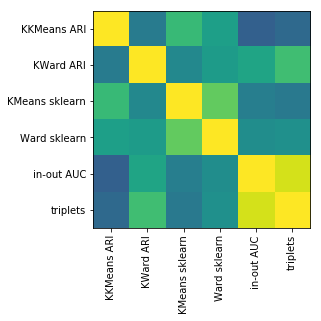

In [20]:
plt.imshow([[np.abs(a[i][j]) for j in range(6)] for i in range(6)], vmin=0, vmax=1)
plt.xticks(range(6), ['KKMeans ARI', 'KWard ARI', 'KMeans sklearn', 'Ward sklearn', 'in-out AUC', 'triplets'], rotation='vertical')
plt.yticks(range(6), ['KKMeans ARI', 'KWard ARI', 'KMeans sklearn', 'Ward sklearn', 'in-out AUC', 'triplets']);

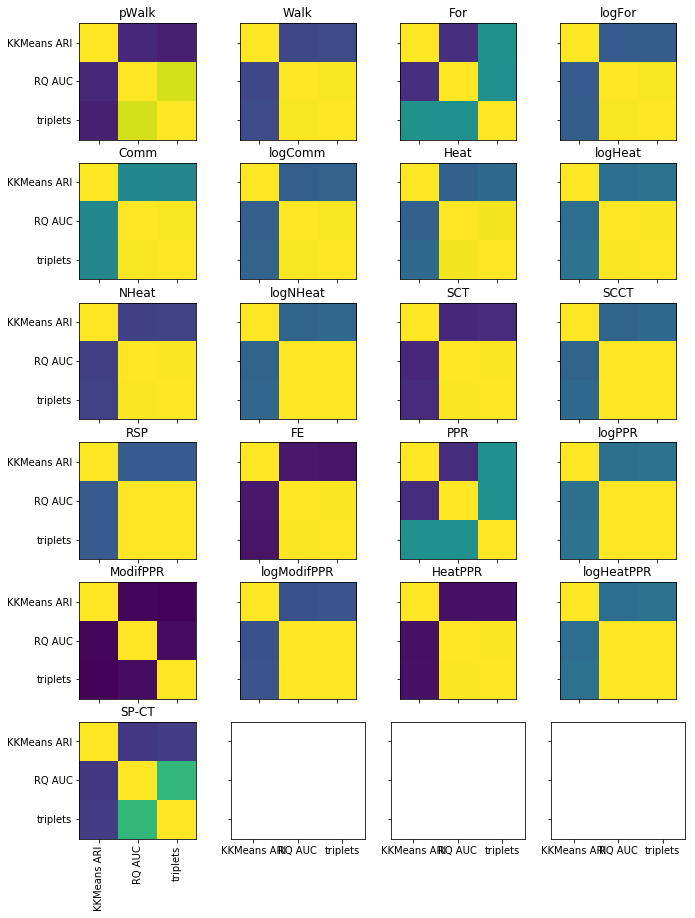

In [49]:
fig, ax = plt.subplots(6, 4, figsize=(11, 15), sharex=True, sharey=True)
for idx, x in enumerate(good_results):
    chain_of_chains = [
        np.array(KKMeans_ARI[x]),
#         np.array(KWard_ARI[x]),
#         np.array(KMeans_sklearn_ARI[x]),
#         np.array(Ward_sklearn_ARI[x]),
        np.array(rq[x]),
        np.array(triplet[x])
    ]
    
    a = defaultdict(lambda: defaultdict(lambda: 0))
    for i1, c1 in enumerate(chain_of_chains):
        for i2, c2 in enumerate(chain_of_chains):
            a[i1][i2] = ranking(c1, c2)
            
    ax[idx // 4][idx % 4].imshow([[np.abs(a[i][j]) for j in range(3)] for i in range(3)], vmin=0, vmax=1)
    ax[idx // 4][idx % 4].set_xticks(range(3)) # 'KWard ARI', 'KMeans sklearn', 'Ward sklearn',
    ax[idx // 4][idx % 4].set_xticklabels(['KKMeans ARI', 'RQ AUC', 'triplets'], rotation=90)
    ax[idx // 4][idx % 4].set_yticks(range(3)) # 'KWard ARI', 'KMeans sklearn', 'Ward sklearn',
    ax[idx // 4][idx % 4].set_yticklabels(['KKMeans ARI', 'RQ AUC', 'triplets'])
    ax[idx // 4][idx % 4].set_title(x)
#     plt.show()

In [50]:
chain_KKMeans_ARI_avg = np.array(list([KKMeans_ARI_mean[x] for x in good_results]))
chain_KWard_ARI_avg = np.array(list([KWard_ARI_mean[x] for x in good_results]))
chain_KMeans_sklearn_ARI_avg = np.array(list([KMeans_sklearn_ARI_mean[x] for x in good_results]))
chain_Ward_sklearn_ARI_avg = np.array(list([Ward_sklearn_ARI_mean[x] for x in good_results]))
chain_rq_avg = np.array(list([rq_avg[x] for x in good_results]))
chain_triplet_avg = np.array(list([triplet_avg[x] for x in good_results]))

chain_of_chains_avg = [
    chain_KKMeans_ARI_avg,
#     chain_KWard_ARI_avg,
#     chain_KMeans_sklearn_ARI_avg,
#     chain_Ward_sklearn_ARI_avg,
    chain_rq_avg,
    chain_triplet_avg
]

In [51]:
a = defaultdict(lambda: defaultdict(lambda: 0))
for i1, c1 in enumerate(chain_of_chains_avg):
    for i2, c2 in enumerate(chain_of_chains_avg):
        a[i1][i2] = ranking(c1, c2)

In [52]:
a

defaultdict(<function __main__.<lambda>()>,
            {0: defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {0: 1.0,
                          1: 0.15714285714285714,
                          2: 0.13409090909090904}),
             1: defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {0: 0.15714285714285714,
                          1: 1.0,
                          2: 0.9464285714285714}),
             2: defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {0: 0.13409090909090904,
                          1: 0.9464285714285714,
                          2: 1.0})})

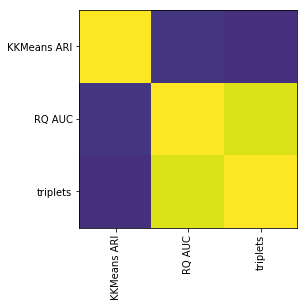

In [53]:
plt.imshow([[np.abs(a[i][j]) for j in range(3)] for i in range(3)], vmin=0, vmax=1)
# 'KWard ARI', 'KMeans sklearn', 'Ward sklearn',
plt.xticks(range(3), ['KKMeans ARI',  'RQ AUC', 'triplets'], rotation='vertical')
plt.yticks(range(3), ['KKMeans ARI',  'RQ AUC', 'triplets']);